In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torch

import bvcopula
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
path_models = '/home/nina/models'
path_exp = '/home/nina/VRData/Processing/pkls'

In [2]:
animal = 'ST263'
dayN = 4
day_name = f"Day{dayN}"
exp_pref = f"{animal}_{day_name}"
n1,n2 = 6,7

In [6]:
points = torch.linspace(0,1,20)

likelihoods = utils.get_likelihoods(f"{path_models}/{exp_pref}/summary.pkl",n1,n2)
weights_file = f"{path_models}/{exp_pref}/model_{n1}-{n2}.pth"

%time model = utils.get_model(weights_file, likelihoods, torch.device('cpu')) 
%time (ym, y, dy) = model.MI(points)

['/home/nina/models/ST263_Day4/model_6-7.pth']
CPU times: user 4.52 ms, sys: 564 µs, total: 5.09 ms
Wall time: 4.77 ms
CPU times: user 51.4 s, sys: 490 ms, total: 51.9 s
Wall time: 1.75 s


(-0.5, 0)

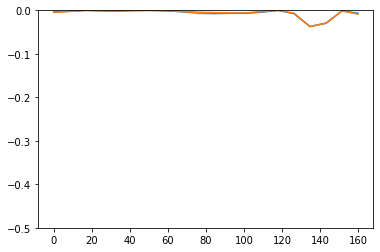

In [7]:
plt.plot(np.linspace(0,160,len(y)),y)
plt.fill_between(np.linspace(0,160,len(y)),y-dy,y+dy, alpha=0.3)
plt.plot(np.linspace(0,160,len(ym)),ym)
plt.ylim(-.5,0)

In [11]:
X,_ = utils.load_experimental_data(path_exp, animal, day_name, 0, 1)

In [13]:
device = torch.device('cuda:0')
f_mc_size = 5
model = utils.get_model(weights_file, likelihoods, device) 
S = torch.tensor(X).float().squeeze().to(device)
with torch.no_grad():
    Fs = model(S).rsample(torch.Size([f_mc_size])) 
    #[samples_f, copulas, stimuli(positions)]
print(S.shape)

['/home/nina/models/ST263_Day4/model_6-7.pth']
torch.Size([22384])


In [15]:
%time MI,sem=model.likelihood.stimMI(S,Fs,s_mc_size=200,r_mc_size=20,sR_mc_size=1000,sem_tol=5*1e-3)
#,sem_tol=1e-3,  
print(f"{MI.mean().item():.3}±{MI.std().item():.3}")

Start calculating p(r) 0
Finished in 10 steps
0.00935,0.000215,0.00914,                    0.772,0.157
CPU times: user 430 ms, sys: 92.5 ms, total: 522 ms
Wall time: 520 ms
0.00914±0.00191


In [16]:
sem.max()/(MI.max()-MI.min())

tensor(0.8221, device='cuda:0')